# Annotate w1118_42D cells with cell type labels

In [1]:
!python --version

Python 3.12.2


## Load required packages 

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import torch
import scvi
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
from scipy.sparse import csr_matrix
from scipy.stats import median_abs_deviation
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import gdown
import copy as cp
import os


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [3]:

print(os.getenv("CUDA_VISIBLE_DEVICES"))
os.environ["CUDA_VISIBLE_DEVICES"]=os.getenv("CUDA_VISIBLE_DEVICES")

0


In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
Tesla P100-PCIE-16GB


In [5]:
sns.set_style('white')
sns.set(font_scale=1.5)
sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()
sc.settings.verbosity = 3

scanpy==1.10.0 anndata==0.10.6 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==1.5.3 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


## Read FCA reference data and w1118_42d data

In [6]:

## Set up I/O directories
basepath = Path("/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/")
inputpath = basepath.joinpath('analysis','preprocess')
referencepath = basepath.joinpath('reference','FCA_head')
outputpath = basepath.joinpath('analysis','scarches')
outputfile = basepath.joinpath('analysis','scarches','w1118_42D_annotated.h5ad')


In [7]:
## Read in count matrix
#w1118_42d = sc.read_10x_mtx(
#    inputpath.joinpath('w1118_42D','outs','filtered_feature_bc_matrix'),
#    var_names="gene_symbols",  
#    cache=True)

## Read sctk-qc h5ad 
w1118_42d = sc.read_h5ad(inputpath.joinpath("w1118_42d_slim.h5ad"))
w1118_42d.raw = w1118_42d

w1118_42d

AnnData object with n_obs × n_vars = 9033 × 16507
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_barcode', 'column_name', 'sample', 'sum', 'detected', 'percent.top_50', 'percent.top_100', 'percent.top_200', 'percent.top_500', 'total', 'doubletFinder_doublet_score_resolution_1.5', 'doubletFinder_doublet_label_resolution_1.5', 'scds_cxds_score', 'scds_cxds_call', 'scds_bcds_score', 'scds_bcds_call', 'scds_hybrid_score', 'scds_hybrid_call', 'decontX_contamination', 'decontX_clusters', 'nCount_decontXcounts', 'nFeature_decontXcounts', 'nCount_RNA', 'nFeature_RNA', 'log1p_total_counts', 'log1p_n_genes_by_counts', 'percent.mt', 'nCount_outlier', 'nFeature_outlier', 'mt_outlier', 'originalexp_snn_res.0.5', 'seurat_clusters', 'soup_group', 'nCount_soupXcounts', 'nFeature_soupXcounts', 'nCount_SCT', 'nFeature_SCT', 'nCount_soupX_SCT', 'nFeature_soupX_SCT', 'nCount_decontX_SCT', 'nFeature_decontX_SCT', 'SCT_snn_res.0.02', 'SCT_snn_res.0.2', 'SCT_snn_res.0.8', 'SCT_snn

In [8]:
## Read reference h5ad 
fca_reference = sc.read_h5ad(referencepath.joinpath("v2_fca_biohub_head_10x_raw.h5ad"))
fca_reference


AnnData object with n_obs × n_vars = 100527 × 13056
    obs: 'age', 'batch', 'batch_id', 'celda_decontx__clusters', 'celda_decontx__contamination', 'celda_decontx__doublemad_predicted_outliers', 'dissection_lab', 'fca_id', 'fly_genetics', 'id', 'log_n_counts', 'log_n_genes', 'n_counts', 'n_genes', 'note', 'percent_mito', 'sample_id', 'scrublet__doublet_scores', 'scrublet__predicted_doublets', 'scrublet__predicted_doublets_based_on_10x_chromium_spec', 'sex', 'tissue', 'leiden_res0.4', 'leiden_res0.6', 'leiden_res0.8', 'leiden_res1.0', 'leiden_res1.2', 'leiden_res1.4', 'leiden_res1.6', 'leiden_res1.8', 'leiden_res10.0', 'leiden_res12.0', 'leiden_res14.0', 'leiden_res16.0', 'leiden_res18.0', 'leiden_res2.0', 'leiden_res20.0', 'leiden_res25.0', 'leiden_res4.0', 'leiden_res50.0', 'leiden_res6.0', 'leiden_res8.0', 'annotation', 'broad_annotation', 'broad_annotation_extrapolated'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

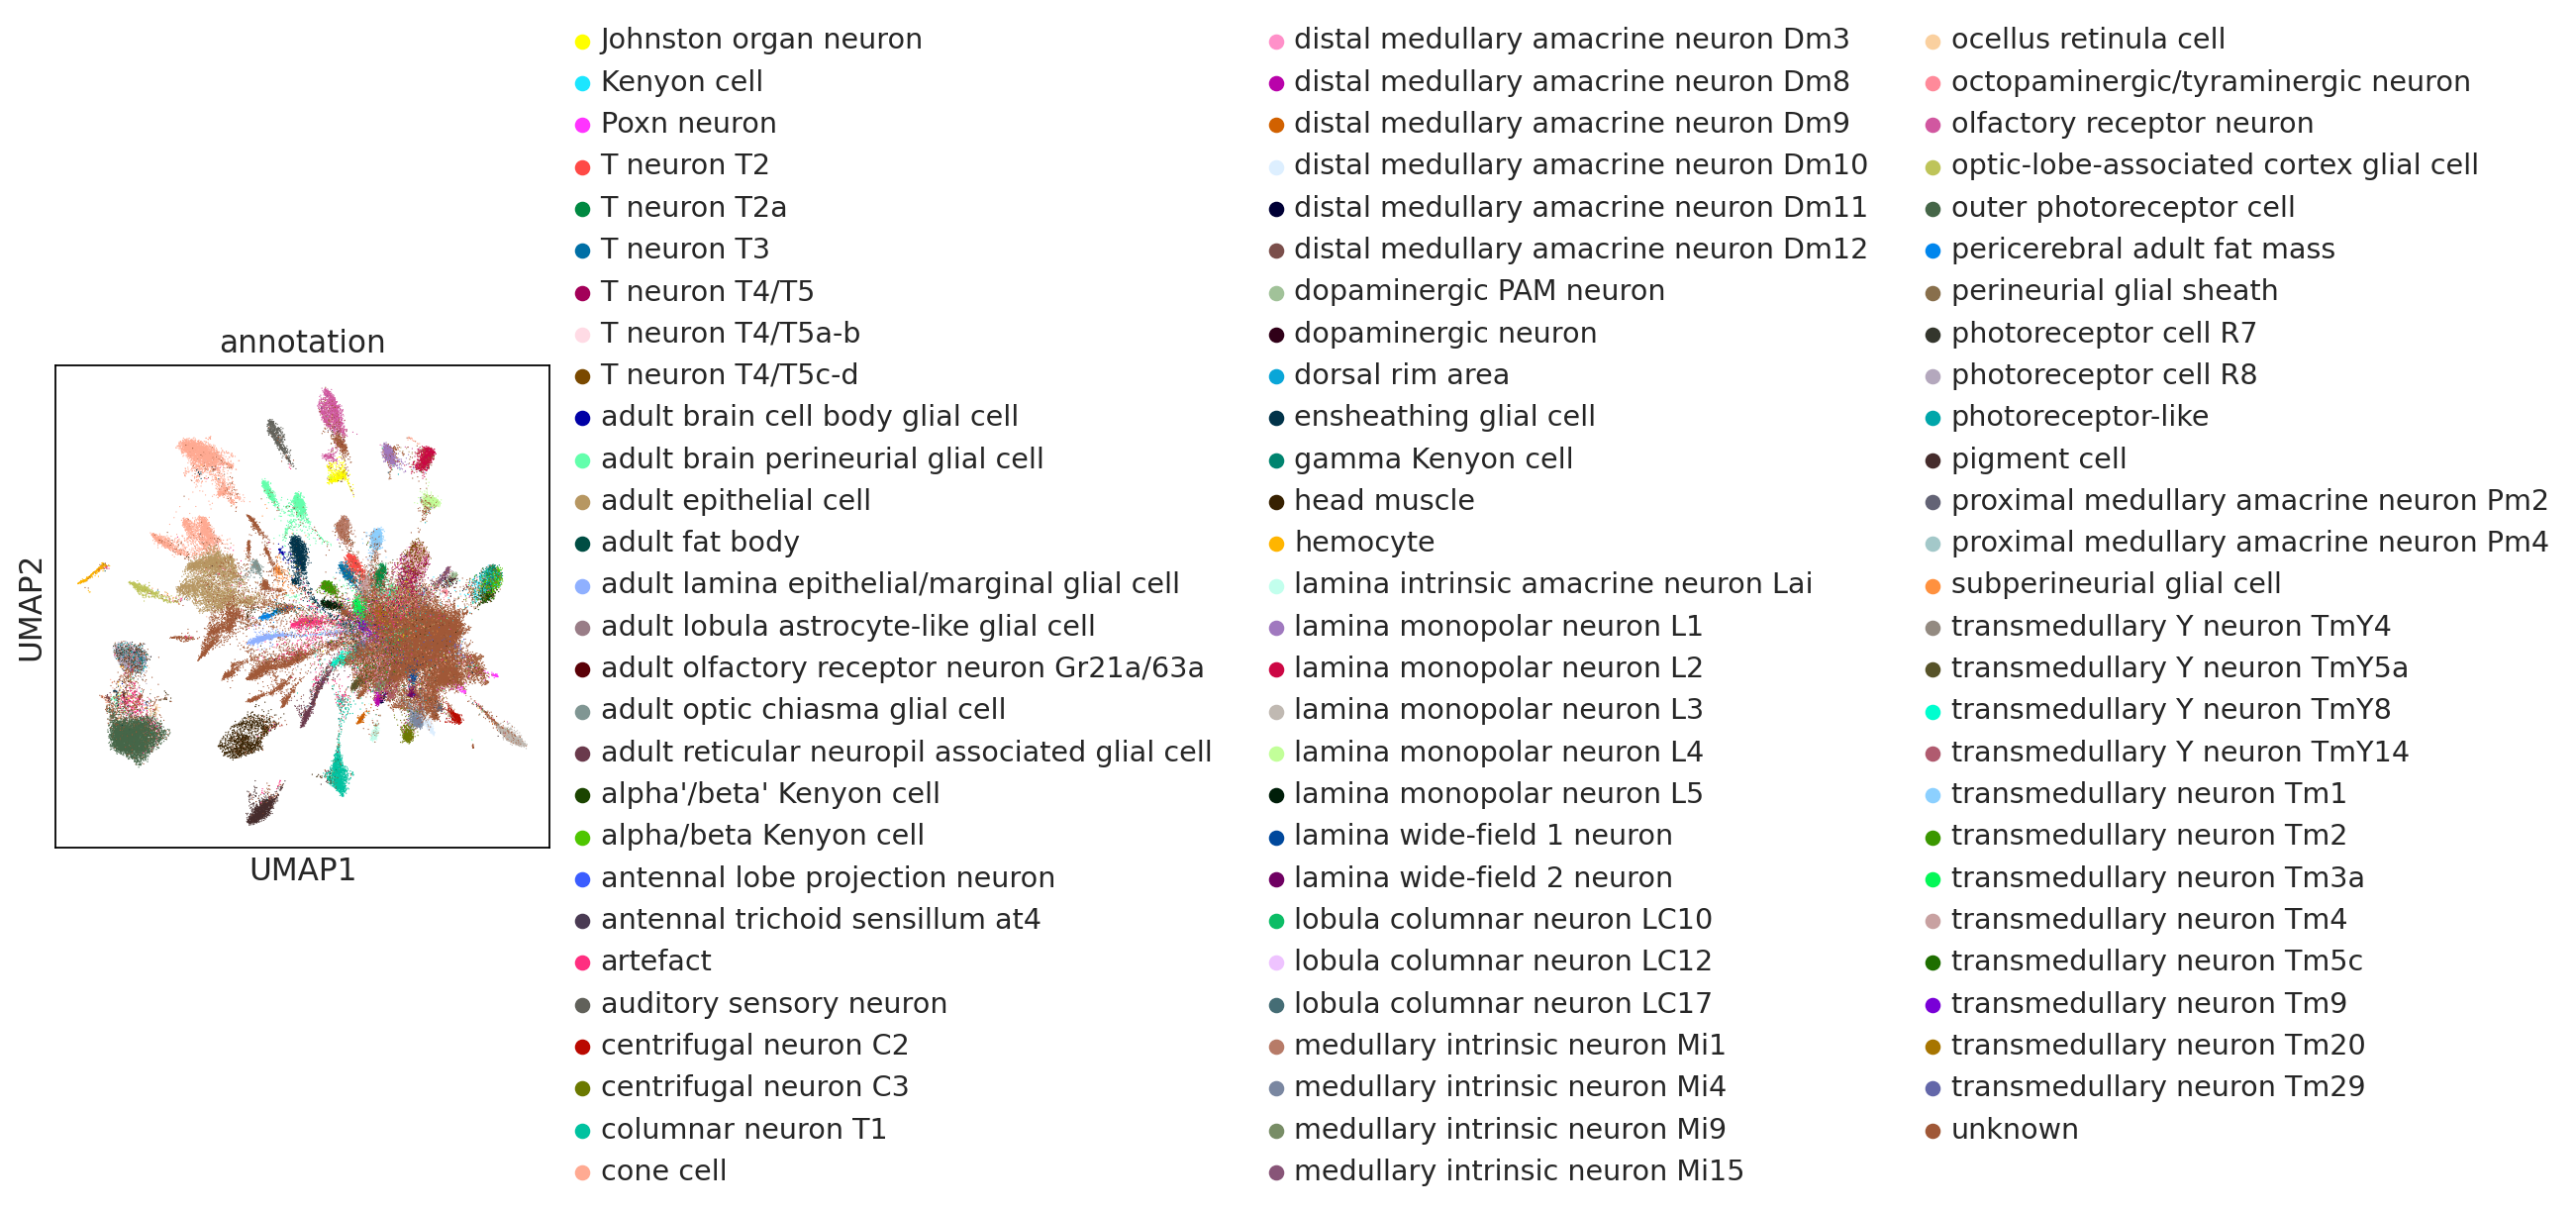

In [9]:
sc.pl.umap(fca_reference,color="annotation")

In [10]:
fca_reference.raw = fca_reference
sc.pp.normalize_total(fca_reference)
sc.pp.log1p(fca_reference)


normalizing counts per cell
    finished (0:00:00)


In [11]:
fca_reference.obs[:5]

age batch  batch_id  \
index                                                                  
AAACCCAGTTACGGAG-d541ae4e__FCA1_MaleFemale_Head    5     0         1   
AAACCCATCCGTACGG-d541ae4e__FCA1_MaleFemale_Head    5     0         1   
AAACGAAGTATGATCC-d541ae4e__FCA1_MaleFemale_Head    5     0         1   
AAACGAATCACCTACC-d541ae4e__FCA1_MaleFemale_Head    5     0         1   
AAACGCTAGAAACCAT-d541ae4e__FCA1_MaleFemale_Head    5     0         1   

                                                 celda_decontx__clusters  \
index                                                                      
AAACCCAGTTACGGAG-d541ae4e__FCA1_MaleFemale_Head                        1   
AAACCCATCCGTACGG-d541ae4e__FCA1_MaleFemale_Head                        1   
AAACGAAGTATGATCC-d541ae4e__FCA1_MaleFemale_Head                        1   
AAACGAATCACCTACC-d541ae4e__FCA1_MaleFemale_Head                        1   
AAACGCTAGAAACCAT-d541ae4e__FCA1_MaleFemale_Head                        3   

                                                 celda_decontx__contamination  \
index                                                                           
AAACCCAGTTACGGAG-d541ae4e__FCA1_MaleFemale_Head                      0.057744   
AAACCCATCCGTACGG-d541ae4e__FCA1_MaleFemale_Head                      0.066588   
AAACGAAGTATGATCC-d541ae4e__FCA1_MaleFemale_Head                      0.182339   
AAACGAATCACCTACC-d541ae4e__FCA1_MaleFemale_Head                      0.587886   
AAACGCTAGAAACCAT-d541ae4e__FCA1_MaleFemale_Head                      0.152492   

                                                 celda_decontx__doublemad_predicted_outliers  \
index                                                                                          
AAACCCAGTTACGGAG-d541ae4e__FCA1_MaleFemale_Head                                        False   
AAACCCATCCGTACGG-d541ae4e__FCA1_MaleFemale_Head                                        False   
AAACGAAGTATGATCC-d541ae4e__FCA1_MaleFemale_Head                                        False   
AAACGAATCACCTACC-d541ae4e__FCA1_MaleFemale_Head                                         True   
AAACGCTAGAAACCAT-d541ae4e__FCA1_MaleFemale_Head                                        False   

                                                dissection_lab fca_id  \
index                                                                   
AAACCCAGTTACGGAG-d541ae4e__FCA1_MaleFemale_Head      Liqun Luo   FCA1   
AAACCCATCCGTACGG-d541ae4e__FCA1_MaleFemale_Head      Liqun Luo   FCA1   
AAACGAAGTATGATCC-d541ae4e__FCA1_MaleFemale_Head      Liqun Luo   FCA1   
AAACGAATCACCTACC-d541ae4e__FCA1_MaleFemale_Head      Liqun Luo   FCA1   
AAACGCTAGAAACCAT-d541ae4e__FCA1_MaleFemale_Head      Liqun Luo   FCA1   

                                                     fly_genetics  \
index                                                               
AAACCCAGTTACGGAG-d541ae4e__FCA1_MaleFemale_Head  yw; UAS-UNC84GFP   
AAACCCATCCGTACGG-d541ae4e__FCA1_MaleFemale_Head  yw; UAS-UNC84GFP   
AAACGAAGTATGATCC-d541ae4e__FCA1_MaleFemale_Head  yw; UAS-UNC84GFP   
AAACGAATCACCTACC-d541ae4e__FCA1_MaleFemale_Head  yw; UAS-UNC84GFP   
AAACGCTAGAAACCAT-d541ae4e__FCA1_MaleFemale_Head  yw; UAS-UNC84GFP   

                                                                             id  \
index                                                                             
AAACCCAGTTACGGAG-d541ae4e__FCA1_MaleFemale_Head  d541ae4e__FCA1_MaleFemale_Head   
AAACCCATCCGTACGG-d541ae4e__FCA1_MaleFemale_Head  d541ae4e__FCA1_MaleFemale_Head   
AAACGAAGTATGATCC-d541ae4e__FCA1_MaleFemale_Head  d541ae4e__FCA1_MaleFemale_Head   
AAACGAATCACCTACC-d541ae4e__FCA1_MaleFemale_Head  d541ae4e__FCA1_MaleFemale_Head   
AAACGCTAGAAACCAT-d541ae4e__FCA1_MaleFemale_Head  d541ae4e__FCA1_MaleFemale_Head   

                                                 ...  leiden_res2.0  \
index                                            ...                  
AAACCCAGTTACGGAG-d541ae4e__FCA1_MaleFemale_Head  .

In [12]:
sc.pp.highly_variable_genes(
    fca_reference,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

extracting highly variable genes
    finished (0:00:18)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [13]:
sca.models.SCVI.setup_anndata(fca_reference, batch_key="batch")

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [14]:
vae = sca.models.SCVI(
    fca_reference,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=True,
    use_layer_norm="both",
    use_batch_norm="none"
)

In [15]:
vae.train(max_epochs=80)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/80:   0%|          | 0/80 [00:00<?, ?it/s]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/80:   1%|▏         | 1/80 [00:06<08:11,  6.22s/it, v_num=1, train_loss_step=142, train_loss_epoch=157]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 3/80:   2%|▎         | 2/80 [00:11<07:43,  5.94s/it, v_num=1, train_loss_step=143, train_loss_epoch=145]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 4/80:   4%|▍         | 3/80 [00:17<07:31,  5.86s/it, v_num=1, train_loss_step=141, train_loss_epoch=142]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 5/80:   5%|▌         | 4/80 [00:23<07:22,  5.82s/it, v_num=1, train_loss_step=139, train_loss_epoch=140]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/80:   6%|▋         | 5/80 [00:29<07:14,  5.80s/it, v_num=1, train_loss_step=142, train_loss_epoch=139]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 7/80:   8%|▊         | 6/80 [00:35<07:08,  5.79s/it, v_num=1, train_loss_step=135, train_loss_epoch=138]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 8/80:   9%|▉         | 7/80 [00:40<07:01,  5.78s/it, v_num=1, train_loss_step=139, train_loss_epoch=138]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 9/80:  10%|█         | 8/80 [00:46<06:55,  5.77s/it, v_num=1, train_loss_step=139, train_loss_epoch=137]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 10/80:  11%|█▏        | 9/80 [00:52<06:48,  5.76s/it, v_num=1, train_loss_step=138, train_loss_epoch=137]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 11/80:  12%|█▎        | 10/80 [00:58<06:42,  5.75s/it, v_num=1, train_loss_step=137, train_loss_epoch=137]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 12/80:  14%|█▍        | 11/80 [01:03<06:36,  5.75s/it, v_num=1, train_loss_step=134, train_loss_epoch=137]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 13/80:  15%|█▌        | 12/80 [01:09<06:30,  5.75s/it, v_num=1, train_loss_step=140, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 14/80:  16%|█▋        | 13/80 [01:15<06:24,  5.75s/it, v_num=1, train_loss_step=139, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 15/80:  18%|█▊        | 14/80 [01:20<06:19,  5.75s/it, v_num=1, train_loss_step=135, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 16/80:  19%|█▉        | 15/80 [01:26<06:13,  5.75s/it, v_num=1, train_loss_step=134, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 17/80:  20%|██        | 16/80 [01:32<06:08,  5.76s/it, v_num=1, train_loss_step=135, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 18/80:  21%|██▏       | 17/80 [01:38<06:03,  5.76s/it, v_num=1, train_loss_step=134, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 19/80:  22%|██▎       | 18/80 [01:44<05:57,  5.77s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 20/80:  24%|██▍       | 19/80 [01:49<05:52,  5.77s/it, v_num=1, train_loss_step=142, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 21/80:  25%|██▌       | 20/80 [01:55<05:46,  5.77s/it, v_num=1, train_loss_step=132, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 22/80:  26%|██▋       | 21/80 [02:01<05:40,  5.77s/it, v_num=1, train_loss_step=134, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 23/80:  28%|██▊       | 22/80 [02:07<05:34,  5.76s/it, v_num=1, train_loss_step=138, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 24/80:  29%|██▉       | 23/80 [02:12<05:28,  5.76s/it, v_num=1, train_loss_step=133, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 25/80:  30%|███       | 24/80 [02:18<05:22,  5.76s/it, v_num=1, train_loss_step=133, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 26/80:  31%|███▏      | 25/80 [02:24<05:16,  5.76s/it, v_num=1, train_loss_step=139, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 27/80:  32%|███▎      | 26/80 [02:30<05:11,  5.77s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 28/80:  34%|███▍      | 27/80 [02:35<05:05,  5.77s/it, v_num=1, train_loss_step=133, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 29/80:  35%|███▌      | 28/80 [02:41<05:00,  5.77s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 30/80:  36%|███▋      | 29/80 [02:47<04:54,  5.77s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 31/80:  38%|███▊      | 30/80 [02:53<04:48,  5.77s/it, v_num=1, train_loss_step=132, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 32/80:  39%|███▉      | 31/80 [02:58<04:41,  5.75s/it, v_num=1, train_loss_step=137, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 33/80:  40%|████      | 32/80 [03:04<04:35,  5.74s/it, v_num=1, train_loss_step=133, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 34/80:  41%|████▏     | 33/80 [03:10<04:29,  5.73s/it, v_num=1, train_loss_step=132, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 35/80:  42%|████▎     | 34/80 [03:16<04:23,  5.73s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 36/80:  44%|████▍     | 35/80 [03:21<04:18,  5.73s/it, v_num=1, train_loss_step=134, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 37/80:  45%|████▌     | 36/80 [03:27<04:12,  5.73s/it, v_num=1, train_loss_step=133, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 38/80:  46%|████▋     | 37/80 [03:33<04:06,  5.73s/it, v_num=1, train_loss_step=137, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 39/80:  48%|████▊     | 38/80 [03:39<04:00,  5.73s/it, v_num=1, train_loss_step=138, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 40/80:  49%|████▉     | 39/80 [03:44<03:54,  5.72s/it, v_num=1, train_loss_step=135, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 41/80:  50%|█████     | 40/80 [03:50<03:49,  5.74s/it, v_num=1, train_loss_step=133, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 42/80:  51%|█████▏    | 41/80 [03:56<03:44,  5.75s/it, v_num=1, train_loss_step=140, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 43/80:  52%|█████▎    | 42/80 [04:02<03:38,  5.76s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 44/80:  54%|█████▍    | 43/80 [04:07<03:33,  5.77s/it, v_num=1, train_loss_step=129, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 45/80:  55%|█████▌    | 44/80 [04:13<03:27,  5.77s/it, v_num=1, train_loss_step=138, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 46/80:  56%|█████▋    | 45/80 [04:19<03:21,  5.76s/it, v_num=1, train_loss_step=135, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 47/80:  57%|█████▊    | 46/80 [04:25<03:15,  5.75s/it, v_num=1, train_loss_step=138, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 48/80:  59%|█████▉    | 47/80 [04:30<03:09,  5.74s/it, v_num=1, train_loss_step=137, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 49/80:  60%|██████    | 48/80 [04:36<03:03,  5.75s/it, v_num=1, train_loss_step=137, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 50/80:  61%|██████▏   | 49/80 [04:42<02:58,  5.75s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 51/80:  62%|██████▎   | 50/80 [04:48<02:52,  5.75s/it, v_num=1, train_loss_step=135, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 52/80:  64%|██████▍   | 51/80 [04:53<02:46,  5.75s/it, v_num=1, train_loss_step=135, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 53/80:  65%|██████▌   | 52/80 [04:59<02:40,  5.74s/it, v_num=1, train_loss_step=137, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 54/80:  66%|██████▋   | 53/80 [05:05<02:35,  5.75s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 55/80:  68%|██████▊   | 54/80 [05:11<02:29,  5.75s/it, v_num=1, train_loss_step=131, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 56/80:  69%|██████▉   | 55/80 [05:16<02:23,  5.75s/it, v_num=1, train_loss_step=138, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 57/80:  70%|███████   | 56/80 [05:22<02:18,  5.75s/it, v_num=1, train_loss_step=141, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 58/80:  71%|███████▏  | 57/80 [05:28<02:12,  5.77s/it, v_num=1, train_loss_step=135, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 59/80:  72%|███████▎  | 58/80 [05:34<02:06,  5.77s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 60/80:  74%|███████▍  | 59/80 [05:39<02:01,  5.78s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 61/80:  75%|███████▌  | 60/80 [05:45<01:55,  5.77s/it, v_num=1, train_loss_step=135, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 62/80:  76%|███████▋  | 61/80 [05:51<01:49,  5.75s/it, v_num=1, train_loss_step=139, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 63/80:  78%|███████▊  | 62/80 [05:57<01:43,  5.75s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 64/80:  79%|███████▉  | 63/80 [06:02<01:37,  5.75s/it, v_num=1, train_loss_step=135, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 65/80:  80%|████████  | 64/80 [06:08<01:32,  5.76s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 66/80:  81%|████████▏ | 65/80 [06:14<01:26,  5.75s/it, v_num=1, train_loss_step=135, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 67/80:  82%|████████▎ | 66/80 [06:20<01:20,  5.74s/it, v_num=1, train_loss_step=138, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 68/80:  84%|████████▍ | 67/80 [06:25<01:14,  5.73s/it, v_num=1, train_loss_step=134, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 69/80:  85%|████████▌ | 68/80 [06:31<01:08,  5.73s/it, v_num=1, train_loss_step=134, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 70/80:  86%|████████▋ | 69/80 [06:37<01:03,  5.73s/it, v_num=1, train_loss_step=137, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 71/80:  88%|████████▊ | 70/80 [06:43<00:57,  5.73s/it, v_num=1, train_loss_step=134, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 72/80:  89%|████████▉ | 71/80 [06:48<00:51,  5.74s/it, v_num=1, train_loss_step=137, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 73/80:  90%|█████████ | 72/80 [06:54<00:45,  5.75s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 74/80:  91%|█████████▏| 73/80 [07:00<00:40,  5.74s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 75/80:  92%|█████████▎| 74/80 [07:05<00:34,  5.73s/it, v_num=1, train_loss_step=136, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 76/80:  94%|█████████▍| 75/80 [07:11<00:28,  5.73s/it, v_num=1, train_loss_step=139, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 77/80:  95%|█████████▌| 76/80 [07:17<00:22,  5.72s/it, v_num=1, train_loss_step=140, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 78/80:  96%|█████████▋| 77/80 [07:23<00:17,  5.73s/it, v_num=1, train_loss_step=135, train_loss_epoch=136]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 79/80:  98%|█████████▊| 78/80 [07:28<00:11,  5.72s/it, v_num=1, train_loss_step=140, train_loss_epoch=137]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 80/80:  99%|█████████▉| 79/80 [07:34<00:05,  5.71s/it, v_num=1, train_loss_step=137, train_loss_epoch=137]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 80/80: 100%|██████████| 80/80 [07:40<00:00,  5.71s/it, v_num=1, train_loss_step=137, train_loss_epoch=137]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 80/80: 100%|██████████| 80/80 [07:40<00:00,  5.75s/it, v_num=1, train_loss_step=137, train_loss_epoch=137]


In [16]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["batch"] = fca_reference.obs["batch"].tolist()
reference_latent.obs["annotation"] = fca_reference.obs["annotation"].tolist()
reference_latent.obs["broad_annotation"] = fca_reference.obs["broad_annotation"].tolist()
reference_latent.obs["broad_annotation_extrapolated"] = fca_reference.obs["broad_annotation_extrapolated"].tolist()

In [17]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
running Leiden clustering


/scratch/5899713.1.bil-koo-gpu-pub/ipykernel_1022774/1984373453.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(reference_latent)


    finished: found 31 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:23)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:12)


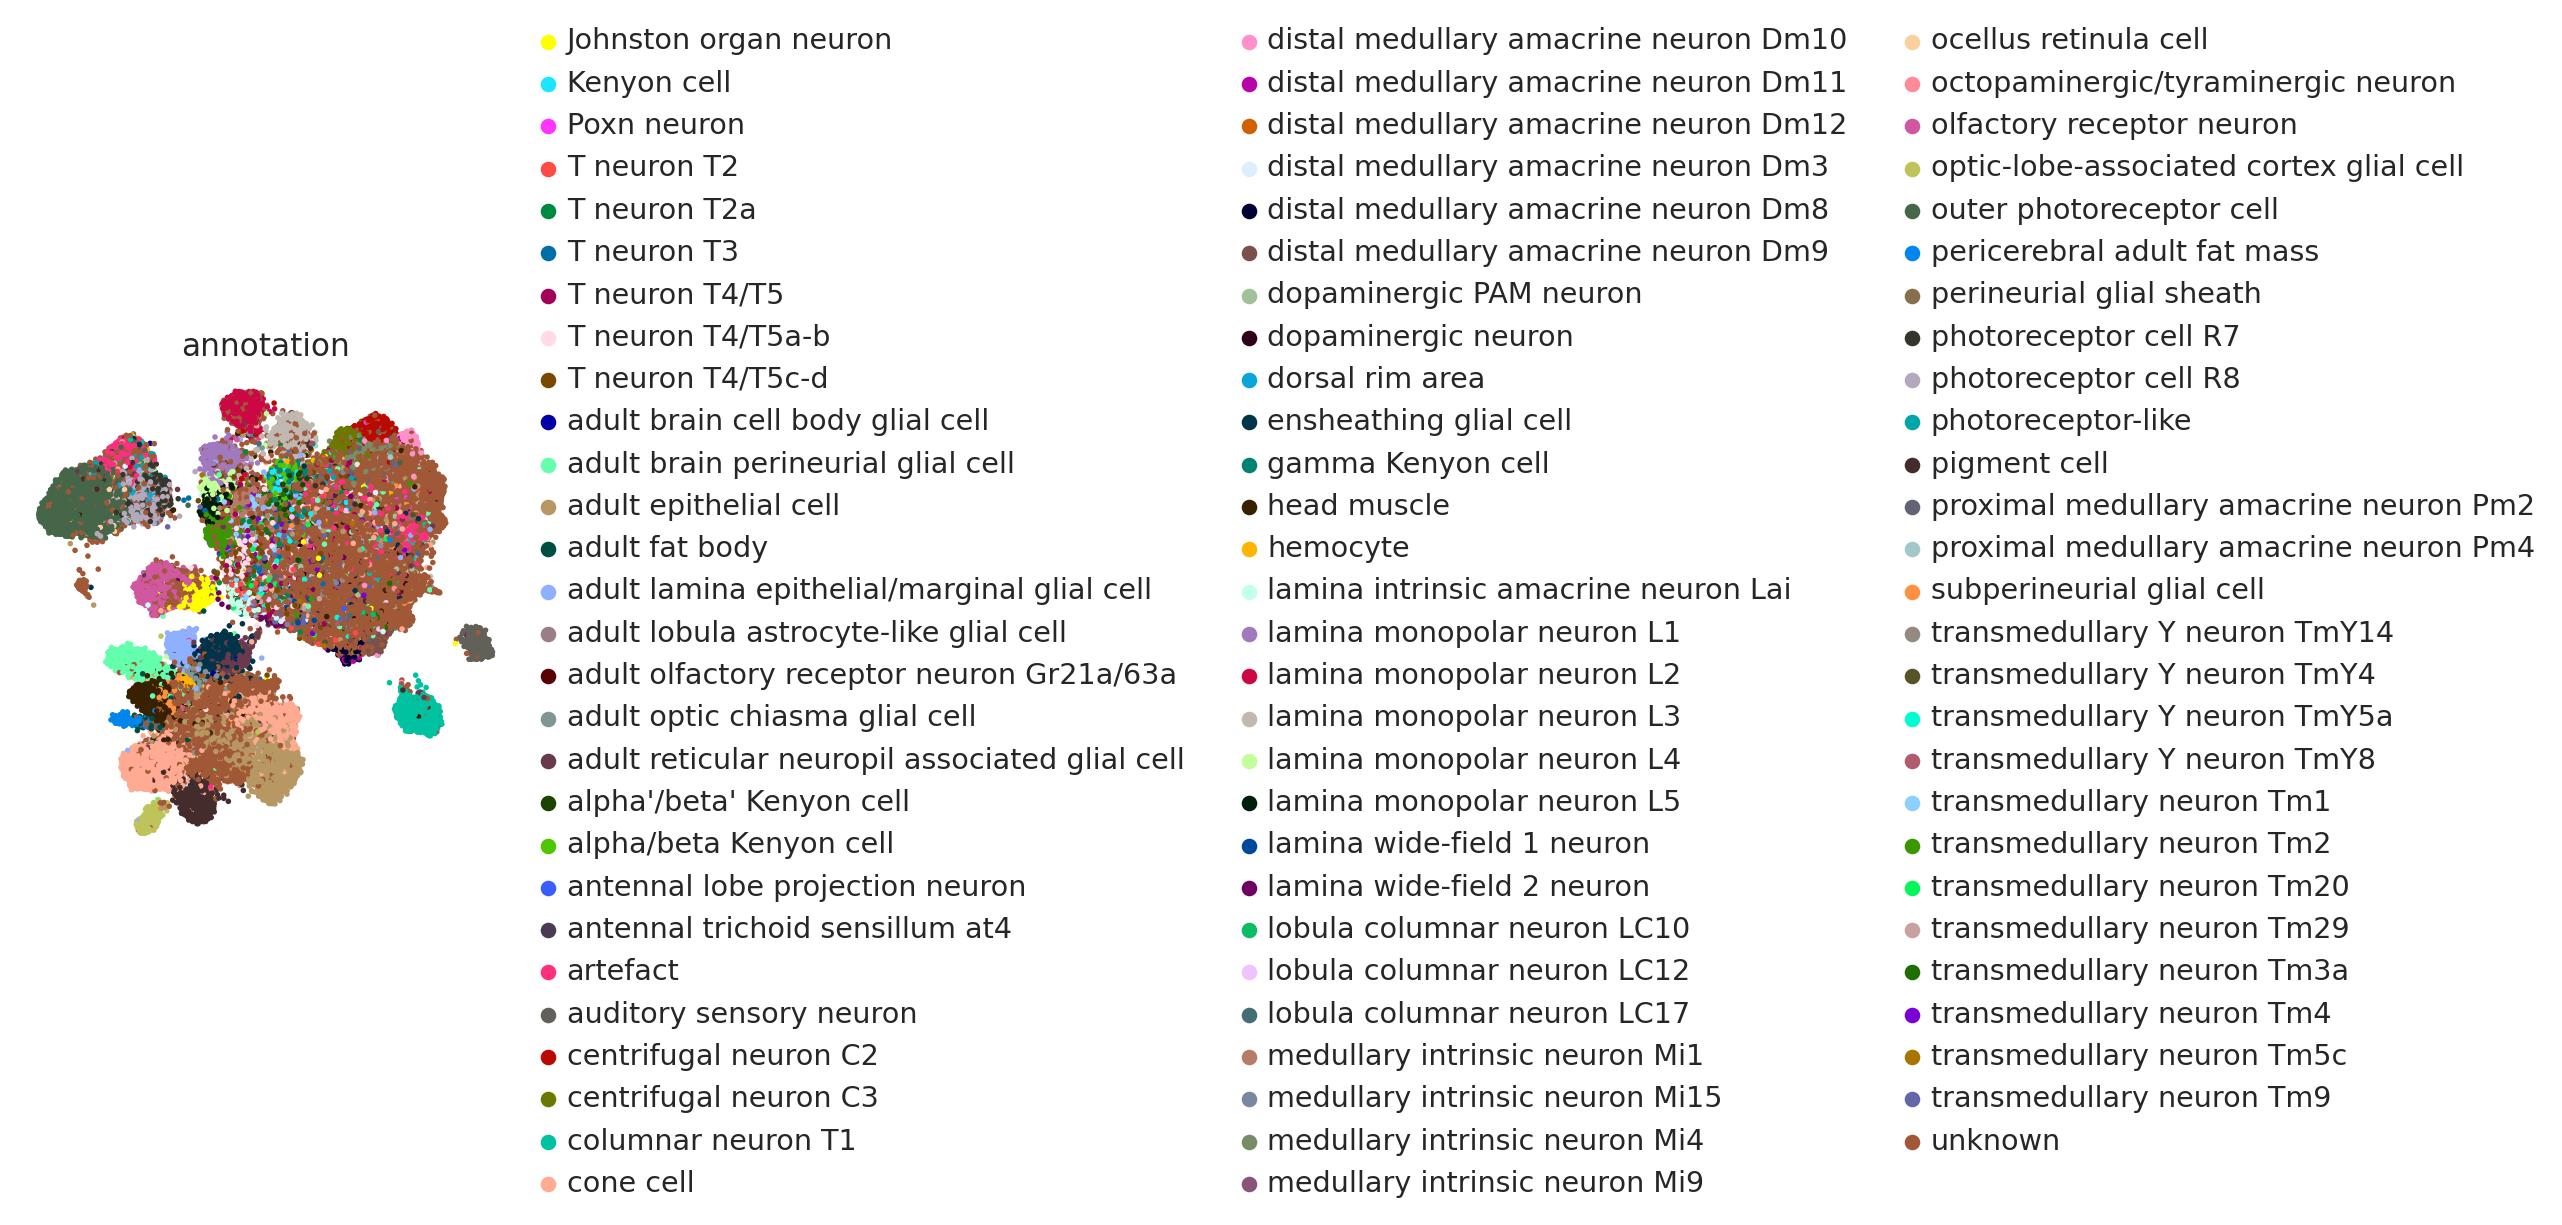

In [18]:
reference_latent.obs['annotation'] = reference_latent.obs['annotation'].astype('category')

sc.pl.umap(reference_latent,
           color=['annotation'],
           frameon=False,
           wspace=0.6, s=25
           )

In [19]:
vae.save(outputpath, overwrite=True)
reference_latent.write(outputpath.joinpath('reference_latent.h5ad'))

In [20]:

#reference_latent = sc.read_h5ad(outputpath.joinpath("reference_latent.h5ad"))
#reference_latent

In [21]:
reference_latent.obs['celltype_batch'] = np.char.add(np.char.add(np.array(reference_latent.obs['annotation'], dtype= str), '-'),
                                             np.array(reference_latent.obs['batch'], dtype=str))

Starting tree:


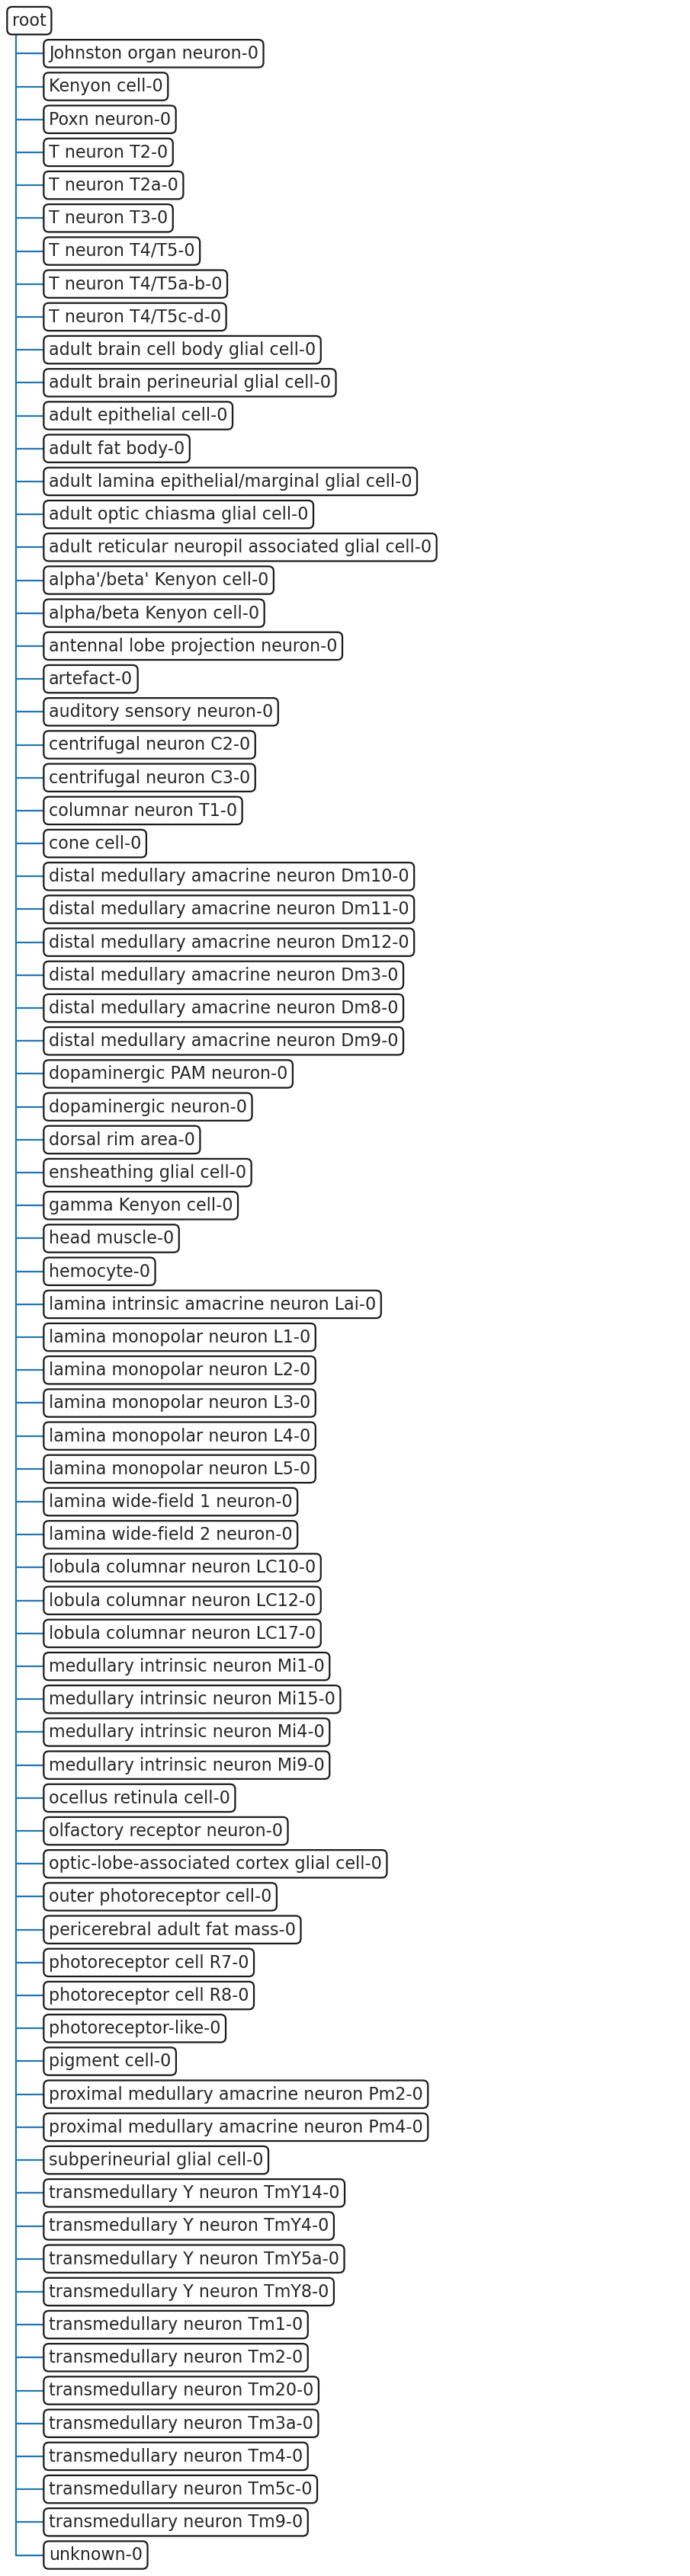


Adding dataset 1 to the tree


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: M

These populations are missing from the tree: 
['Kenyon cell-1' 'Poxn neuron-1' 'T neuron T2a-1' 'T neuron T3-1'
 'T neuron T4/T5-1' 'T neuron T4/T5a-b-1' 'T neuron T4/T5c-d-1'
 'adult brain cell body glial cell-1' 'adult fat body-1'
 'adult optic chiasma glial cell-1' "alpha'/beta' Kenyon cell-1"
 'alpha/beta Kenyon cell-1' 'antennal lobe projection neuron-1'
 'artefact-1' 'distal medullary amacrine neuron Dm12-1'
 'distal medullary amacrine neuron Dm3-1' 'dopaminergic PAM neuron-1'
 'dopaminergic neuron-1' 'dorsal rim area-1' 'ensheathing glial cell-1'
 'gamma Kenyon cell-1' 'lamina monopolar neuron L5-1'
 'lamina wide-field 1 neuron-1' 'lamina wide-field 2 neuron-1'
 'lobula columnar neuron LC10-1' 'lobula columnar neuron LC12-1'
 'lobula columnar neuron LC17-1' 'medullary intrinsic neuron Mi1-1'
 'medullary intrinsic neuron Mi15-1' 'medullary intrinsic neuron Mi9-1'
 'ocellus retinula cell-1' 'octopaminergic/tyraminergic neuron-1'
 'outer photoreceptor cell-1' 'pericerebral adult fa

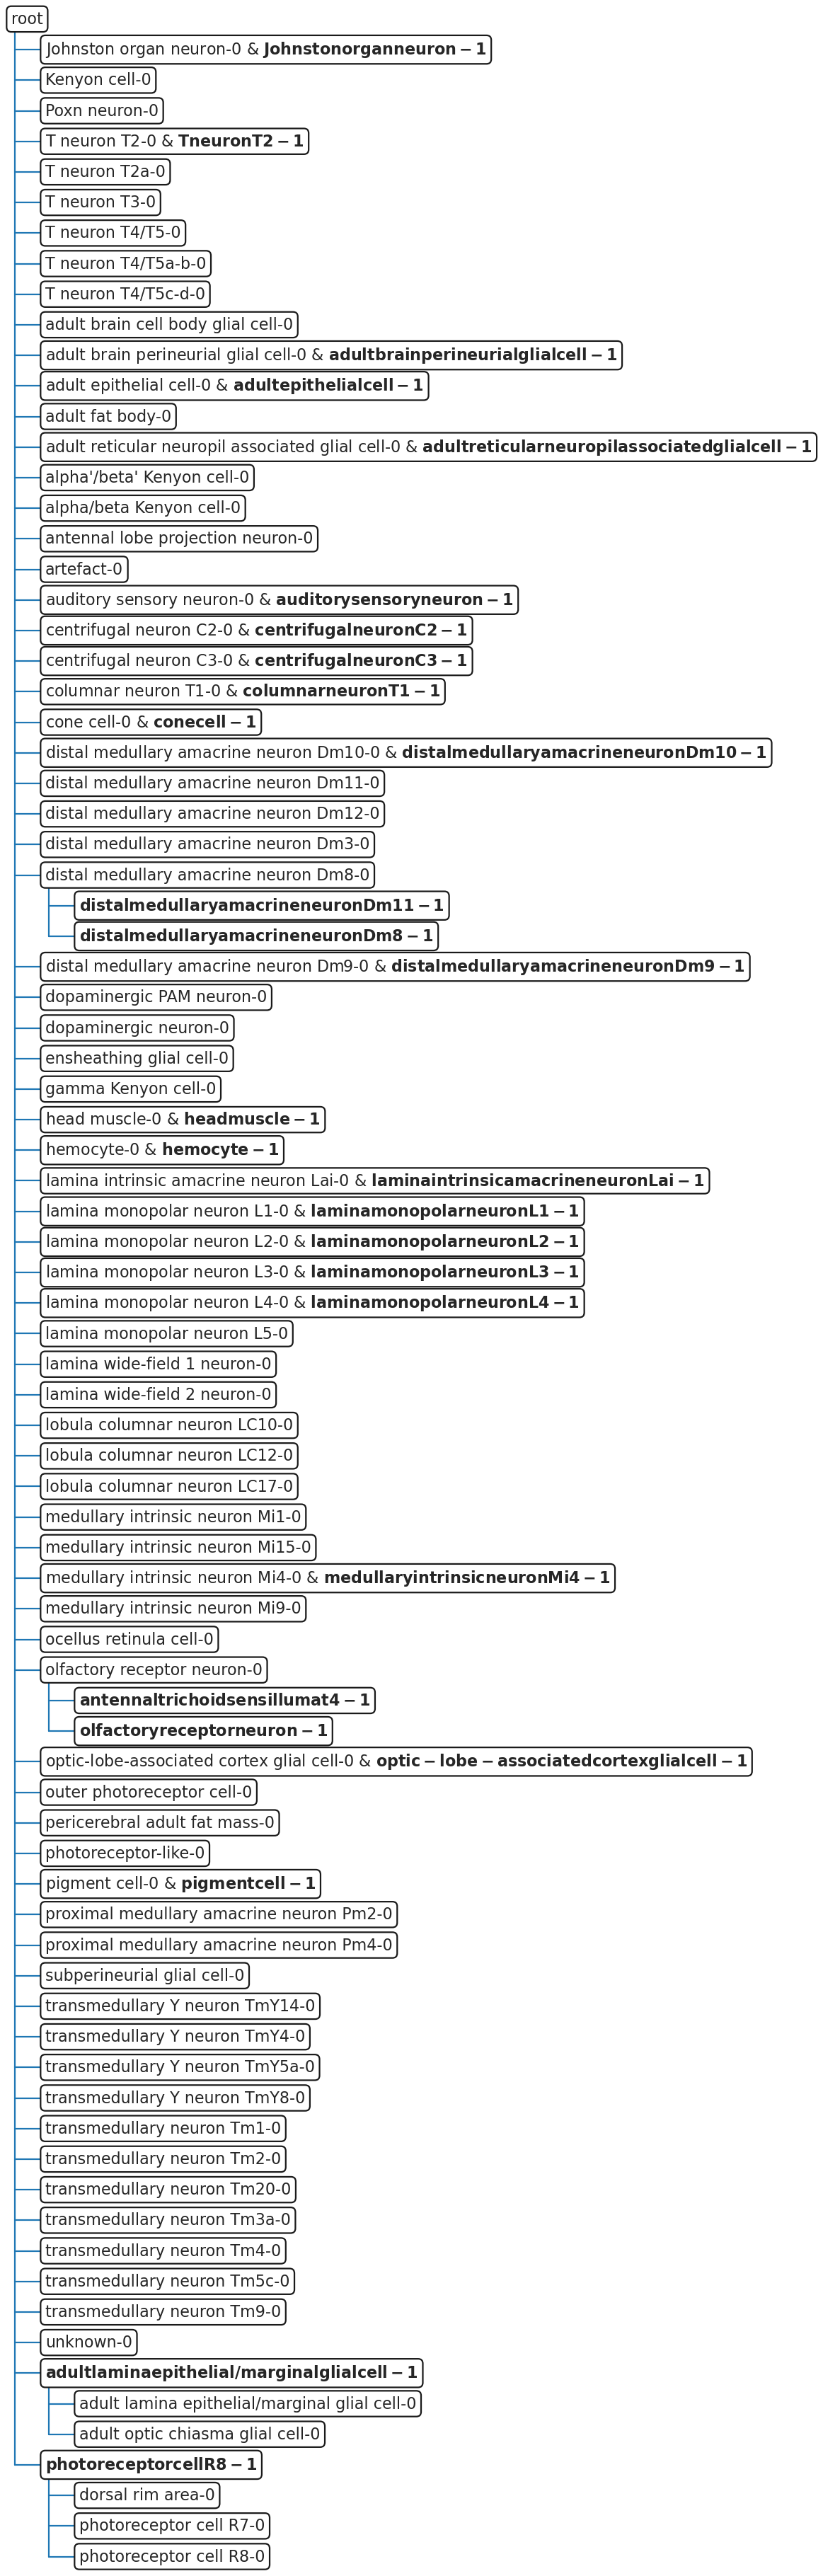


Adding dataset 2 to the tree


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: M

These populations are missing from the tree: 
['Poxn neuron-2' 'T neuron T2a-2' 'T neuron T3-2' 'T neuron T4/T5-2'
 'T neuron T4/T5a-b-2' 'T neuron T4/T5c-d-2'
 'adult brain cell body glial cell-2' 'adult fat body-2'
 'adult optic chiasma glial cell-2' 'antennal lobe projection neuron-2'
 'artefact-2' 'distal medullary amacrine neuron Dm12-2'
 'distal medullary amacrine neuron Dm3-2' 'dopaminergic PAM neuron-2'
 'dopaminergic neuron-2' 'dorsal rim area-2' 'ensheathing glial cell-2'
 'lamina wide-field 1 neuron-2' 'lobula columnar neuron LC10-2'
 'lobula columnar neuron LC12-2' 'lobula columnar neuron LC17-2'
 'medullary intrinsic neuron Mi15-2' 'medullary intrinsic neuron Mi9-2'
 'ocellus retinula cell-2' 'octopaminergic/tyraminergic neuron-2'
 'outer photoreceptor cell-2' 'pericerebral adult fat mass-2'
 'perineurial glial sheath-2' 'photoreceptor cell R8-2'
 'proximal medullary amacrine neuron Pm2-2'
 'proximal medullary amacrine neuron Pm4-2'
 'transmedullary Y neuron TmY14-2' 'tran

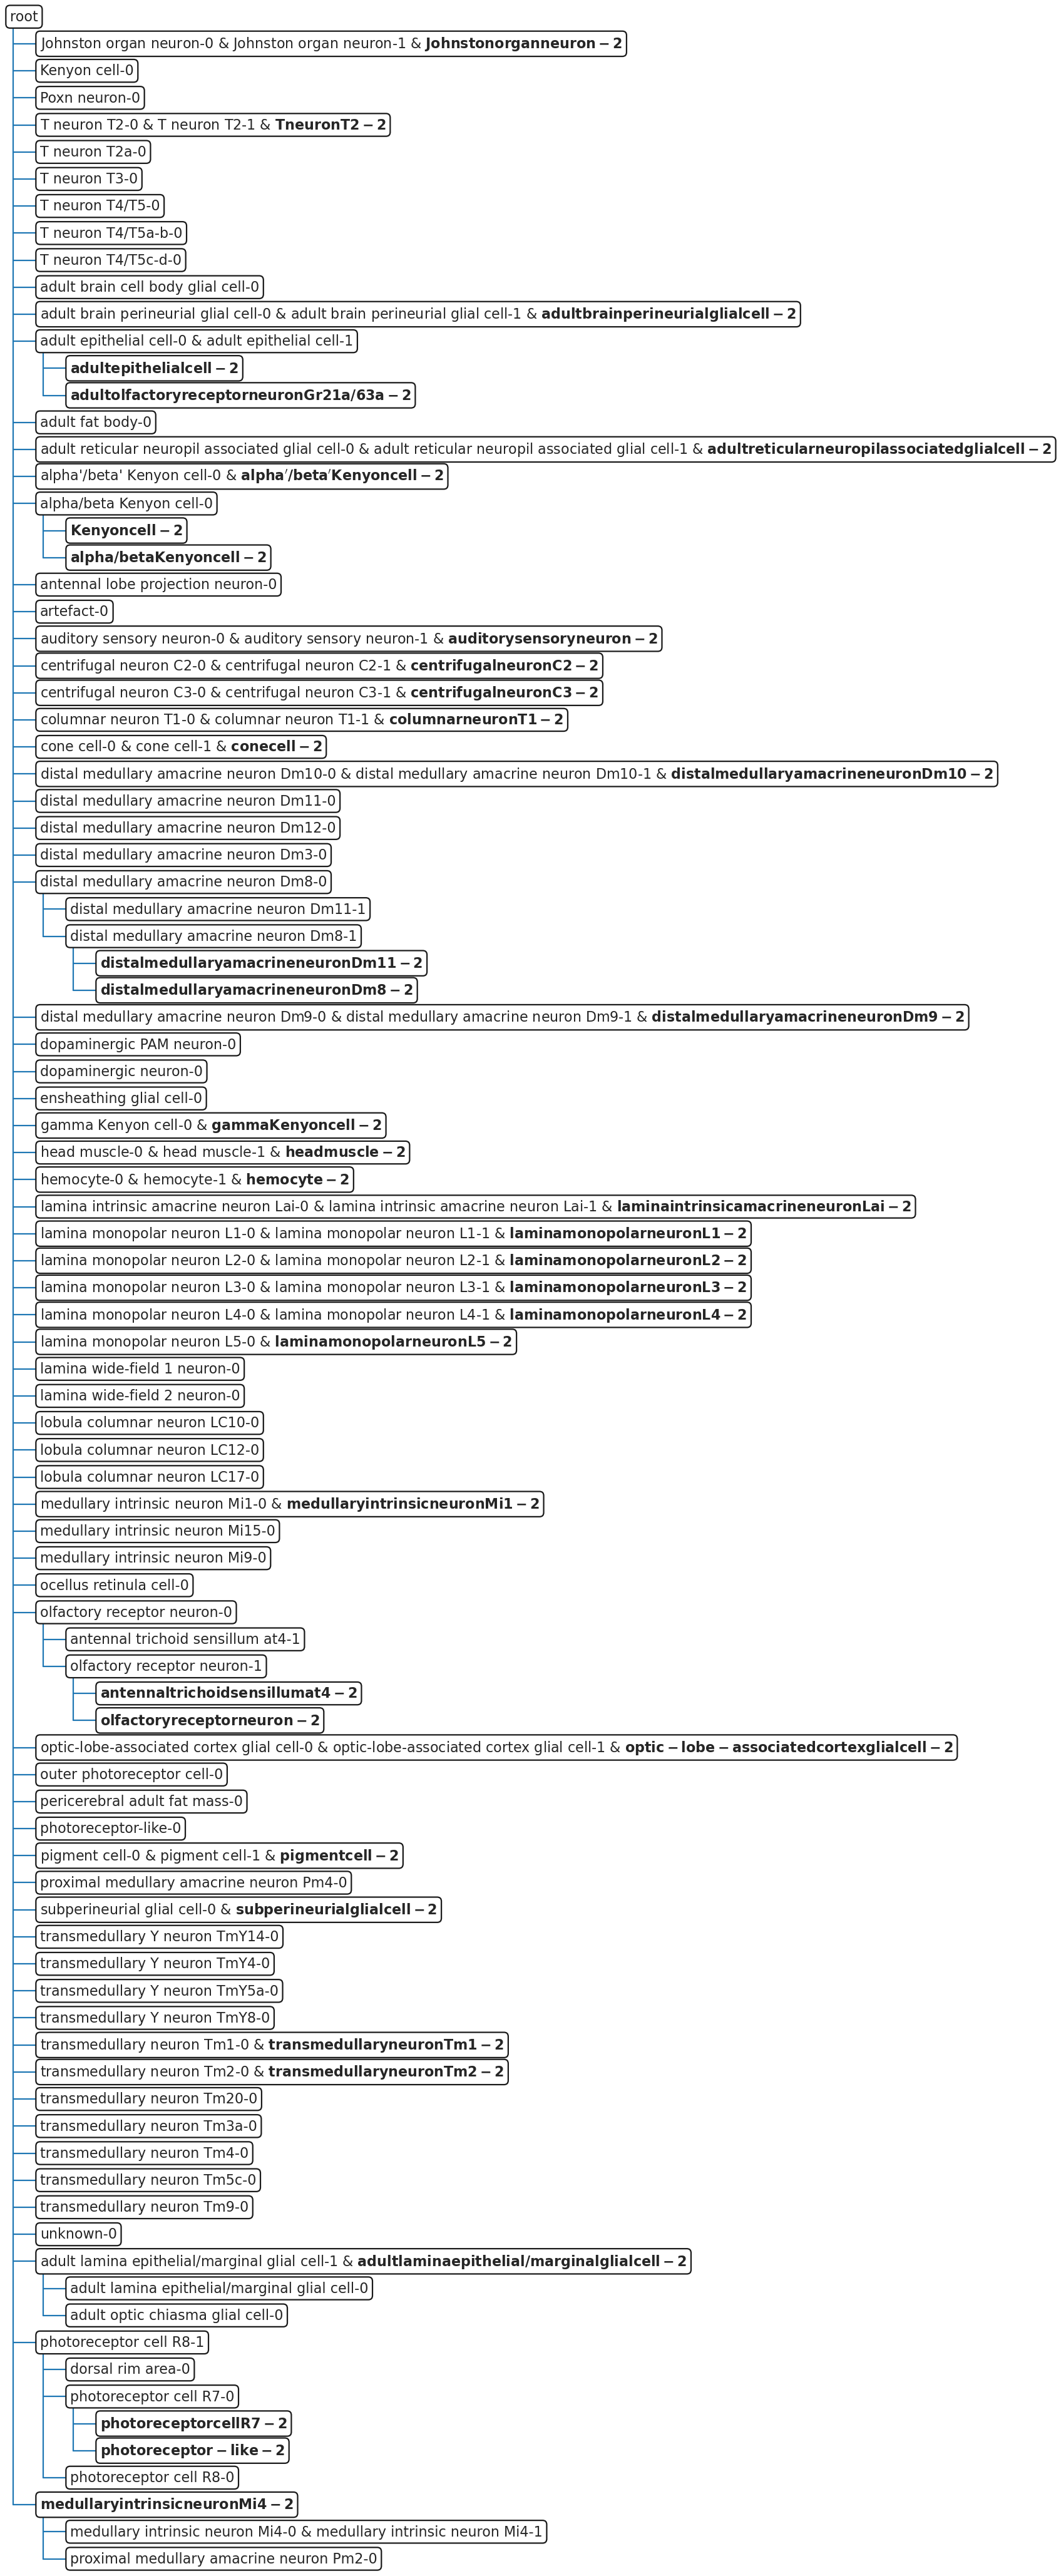


Adding dataset 3 to the tree


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


These populations are missing from the tree: 
['Kenyon cell-3' 'Poxn neuron-3' 'T neuron T3-3' 'T neuron T4/T5-3'
 'T neuron T4/T5a-b-3' 'adult brain cell body glial cell-3'
 'adult fat body-3' 'adult olfactory receptor neuron Gr21a/63a-3'
 'adult optic chiasma glial cell-3' "alpha'/beta' Kenyon cell-3"
 'alpha/beta Kenyon cell-3' 'antennal lobe projection neuron-3'
 'antennal trichoid sensillum at4-3' 'artefact-3'
 'distal medullary amacrine neuron Dm10-3'
 'distal medullary amacrine neuron Dm12-3'
 'distal medullary amacrine neuron Dm3-3' 'dopaminergic PAM neuron-3'
 'dopaminergic neuron-3' 'ensheathing glial cell-3' 'gamma Kenyon cell-3'
 'lamina wide-field 1 neuron-3' 'lamina wide-field 2 neuron-3'
 'lobula columnar neuron LC10-3' 'lobula columnar neuron LC12-3'
 'lobula columnar neuron LC17-3' 'medullary intrinsic neuron Mi15-3'
 'medullary intrinsic neuron Mi9-3' 'octopaminergic/tyraminergic neuron-3'
 'olfactory receptor neuron-3' 'proximal medullary amacrine neuron Pm2-3'
 'pro

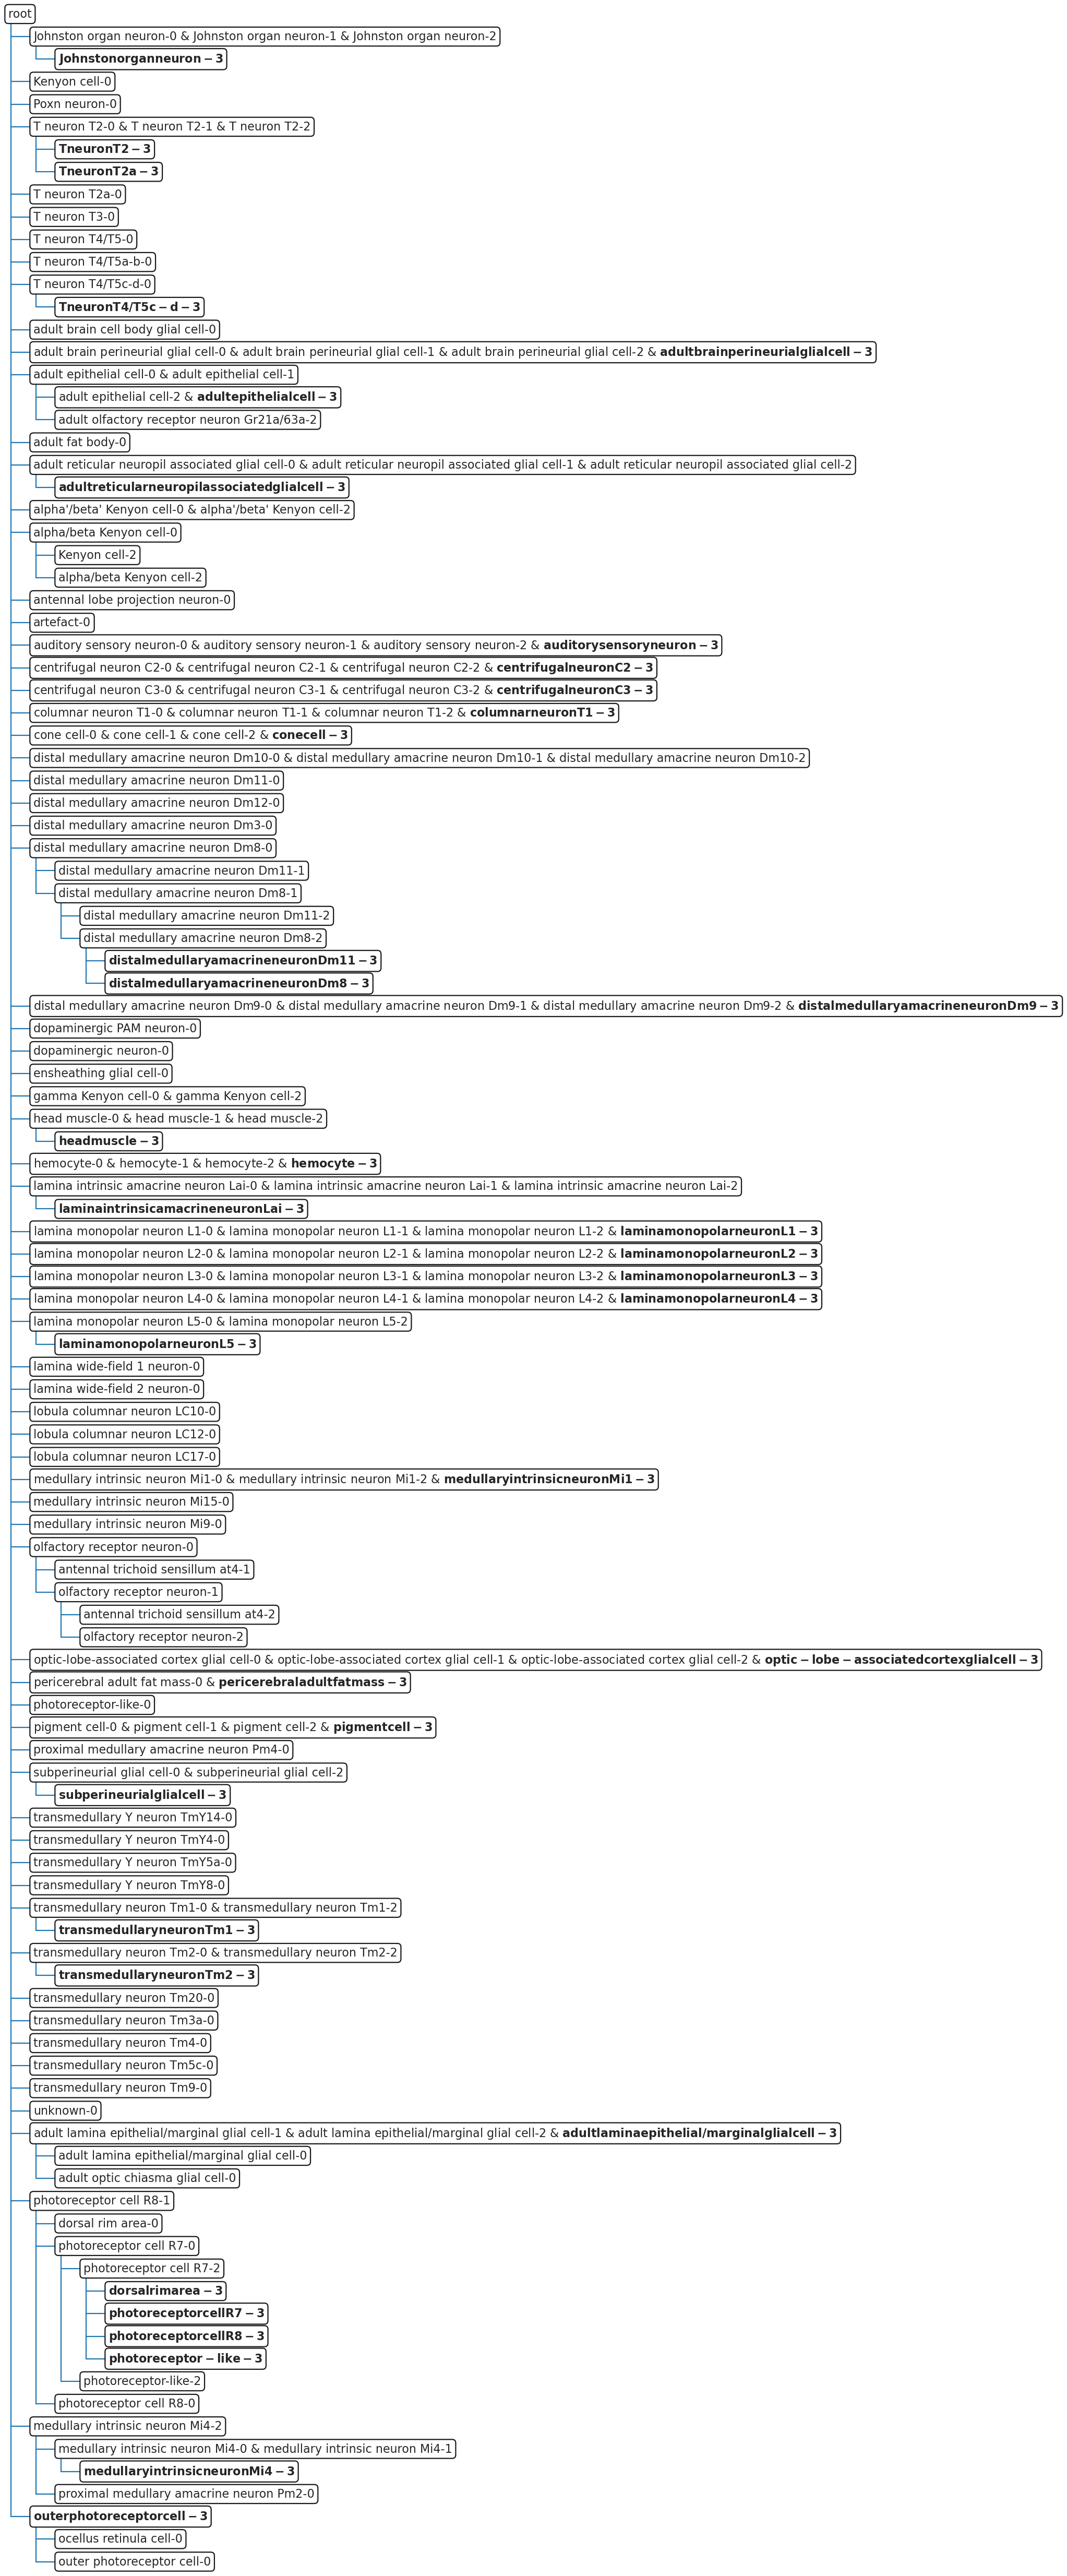


Adding dataset 4 to the tree


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


These populations are missing from the tree: 
['Kenyon cell-4' 'Poxn neuron-4' 'T neuron T2-4' 'T neuron T2a-4'
 'T neuron T3-4' 'T neuron T4/T5-4' 'T neuron T4/T5c-d-4'
 'adult brain cell body glial cell-4' 'adult fat body-4'
 'adult olfactory receptor neuron Gr21a/63a-4'
 "alpha'/beta' Kenyon cell-4" 'alpha/beta Kenyon cell-4'
 'antennal lobe projection neuron-4' 'antennal trichoid sensillum at4-4'
 'artefact-4' 'distal medullary amacrine neuron Dm11-4'
 'distal medullary amacrine neuron Dm12-4'
 'distal medullary amacrine neuron Dm3-4'
 'distal medullary amacrine neuron Dm8-4' 'dopaminergic PAM neuron-4'
 'dopaminergic neuron-4' 'gamma Kenyon cell-4'
 'lamina wide-field 2 neuron-4' 'lobula columnar neuron LC10-4'
 'lobula columnar neuron LC12-4' 'lobula columnar neuron LC17-4'
 'medullary intrinsic neuron Mi15-4' 'medullary intrinsic neuron Mi9-4'
 'ocellus retinula cell-4' 'octopaminergic/tyraminergic neuron-4'
 'olfactory receptor neuron-4' 'photoreceptor cell R7-4'
 'photorecepto

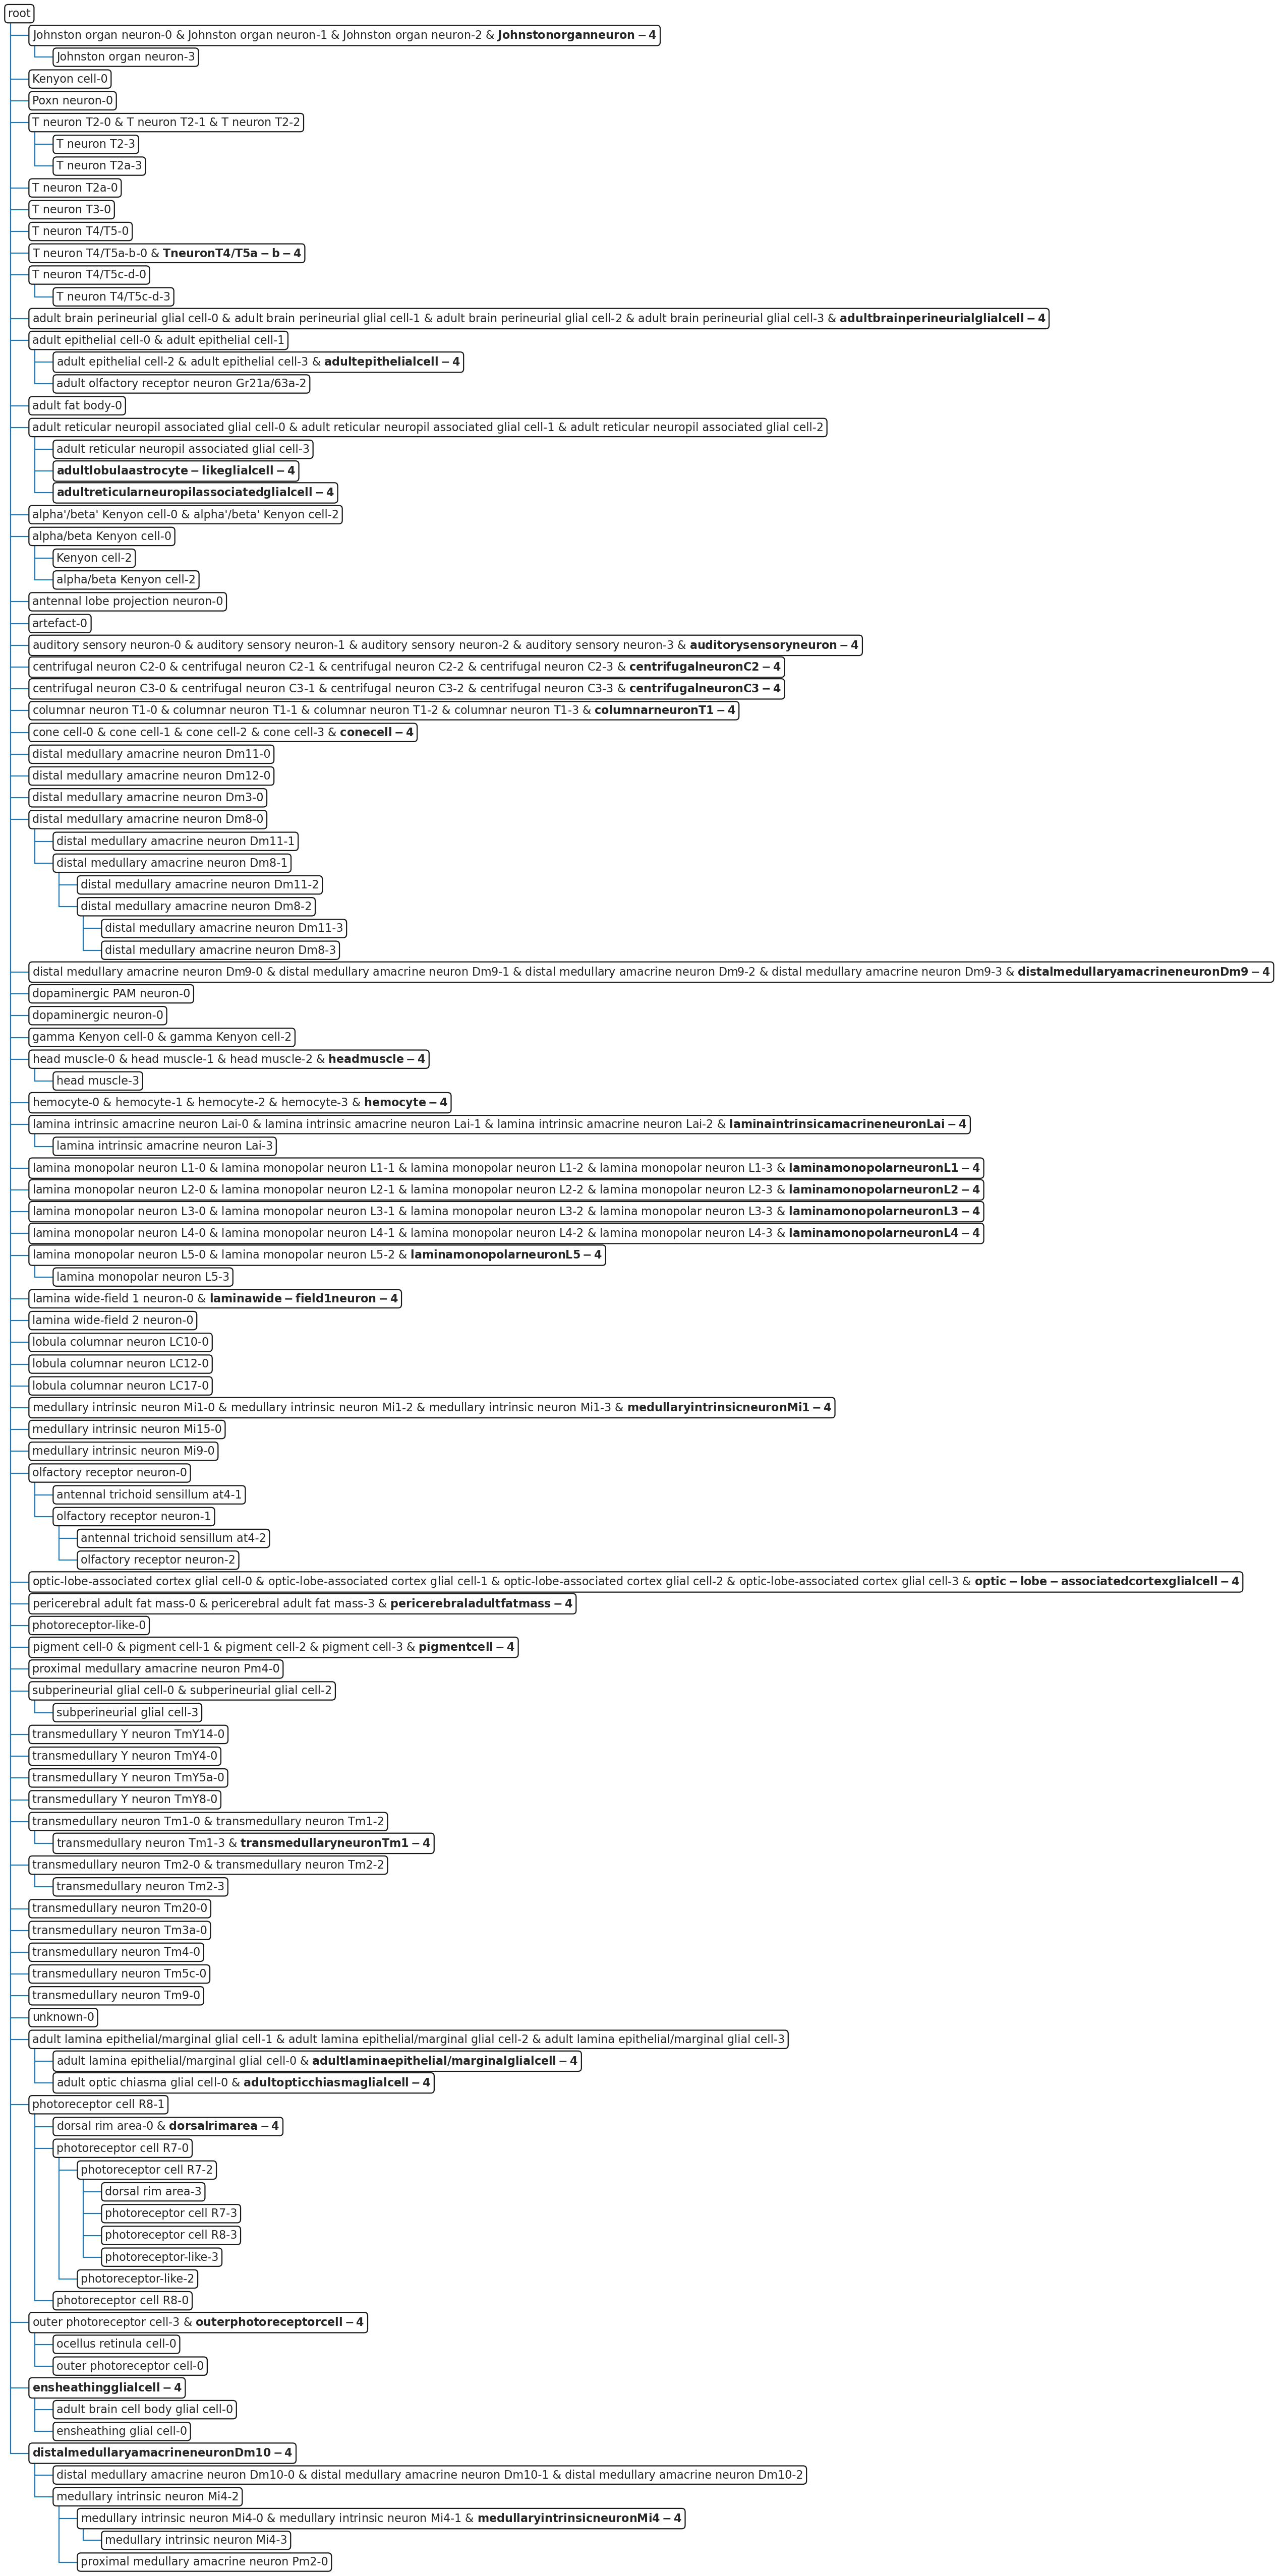


Adding dataset 5 to the tree


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


These populations are missing from the tree: 
['Kenyon cell-5' 'Poxn neuron-5' 'T neuron T2-5' 'T neuron T2a-5'
 'T neuron T3-5' 'T neuron T4/T5-5' 'T neuron T4/T5a-b-5'
 'T neuron T4/T5c-d-5' 'adult brain cell body glial cell-5'
 'adult fat body-5' 'adult olfactory receptor neuron Gr21a/63a-5'
 'antennal lobe projection neuron-5' 'antennal trichoid sensillum at4-5'
 'artefact-5' 'distal medullary amacrine neuron Dm10-5'
 'distal medullary amacrine neuron Dm12-5'
 'distal medullary amacrine neuron Dm3-5' 'dopaminergic PAM neuron-5'
 'dopaminergic neuron-5' 'dorsal rim area-5'
 'lobula columnar neuron LC10-5' 'lobula columnar neuron LC17-5'
 'medullary intrinsic neuron Mi15-5' 'medullary intrinsic neuron Mi9-5'
 'octopaminergic/tyraminergic neuron-5' 'olfactory receptor neuron-5'
 'photoreceptor cell R7-5' 'photoreceptor cell R8-5'
 'photoreceptor-like-5' 'proximal medullary amacrine neuron Pm4-5'
 'subperineurial glial cell-5' 'transmedullary Y neuron TmY14-5'
 'transmedullary Y neuron

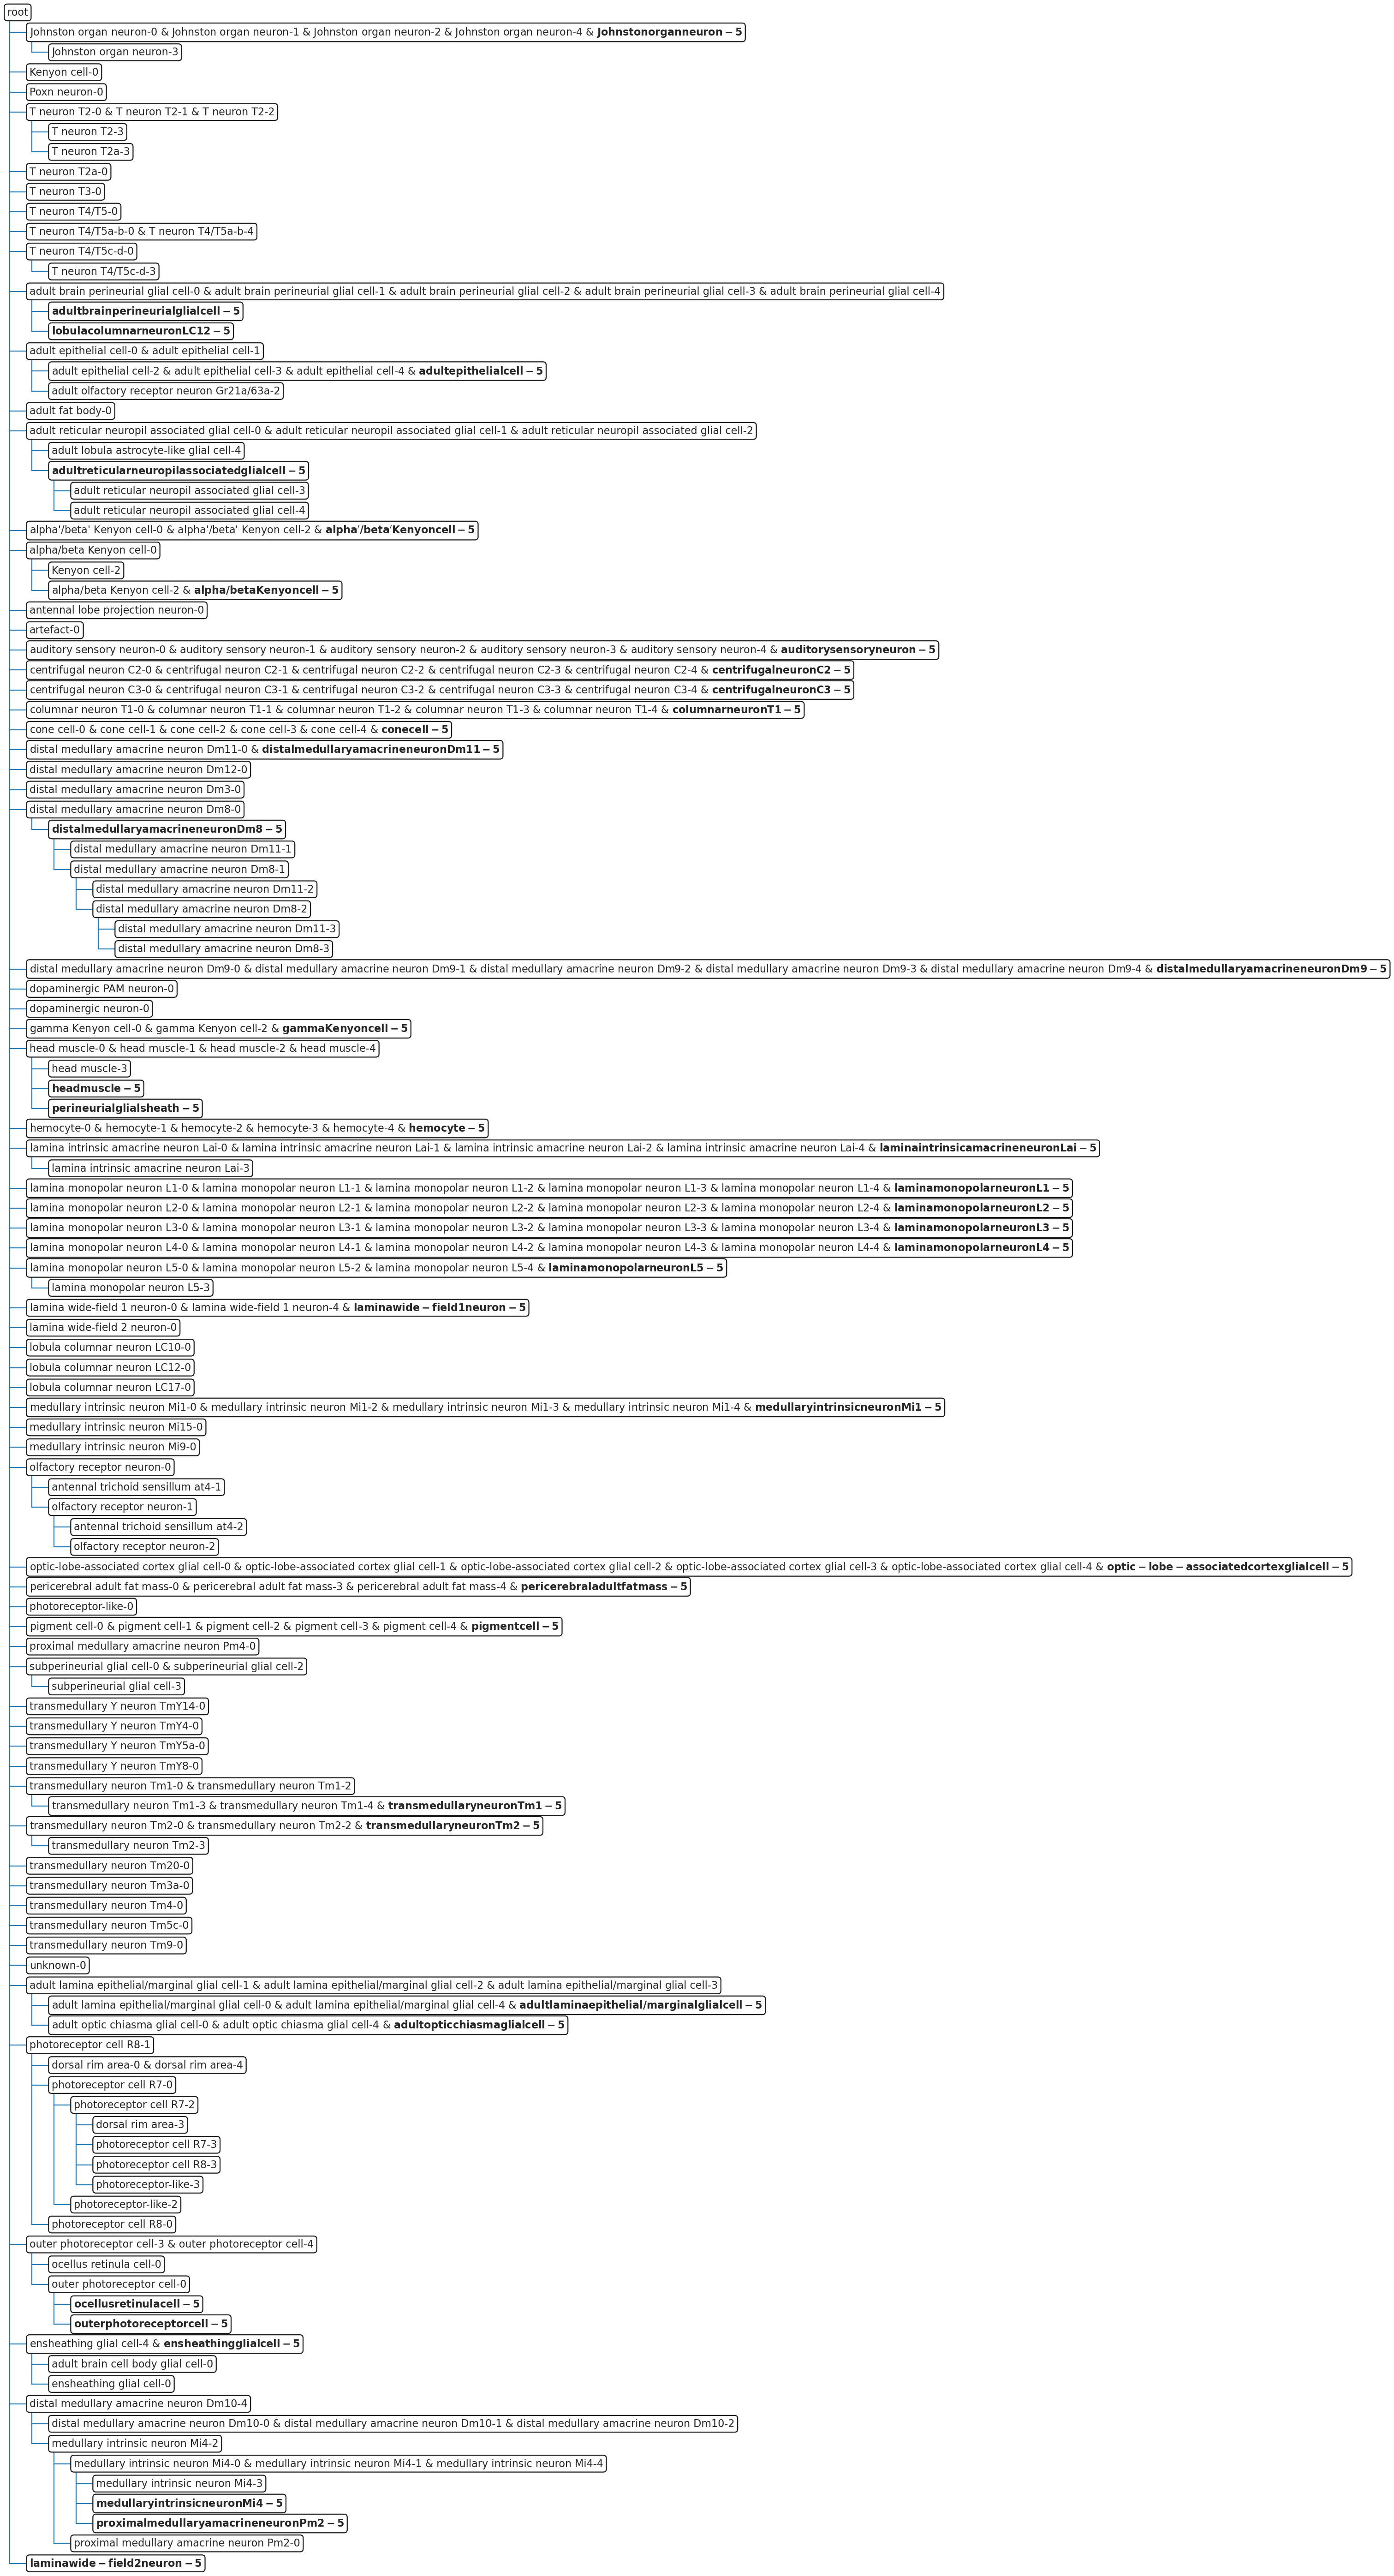


Adding dataset 6 to the tree


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [22]:
batchorder = reference_latent.obs.batch.unique().tolist()
tree_ref, mp_ref = sca.classifiers.scHPL.learn_tree(data = reference_latent,
                batch_key = 'batch',
                batch_order = batchorder ,
                cell_type_key='celltype_batch',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)

In [ ]:
commongenes = list(set(w1118_42d.var_names)& set(fca_reference.var_names))
print(len(commongenes))
w1118_42d = w1118_42d[:, commongenes]
w1118_42d

In [ ]:
w1118_42d = w1118_42d.copy()

In [ ]:
ref_path = "/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/"
model = sca.models.SCVI.load_query_data(
    w1118_42d,
    ref_path ,
    freeze_dropout = True,
)